<a name="Top"></a>
# Data Preprocessing - Table of Content
1. [Handling Missing Data using Pandas](#_1)


2. [Basic methods of Missing Value imputation](#_2)


3. [Identifying and Removing Outliers](#_3)


4. [Feature Scaling](#_4)


5. [Categorical Encoding](#_5)


# Data Cleaning and Preprocessing
Cleaning and Preprocessing is an important part of any Data Science Project. It ensures the validity and quality before the Modelling process. Remember, the model is as good as the data fed to it.

## Terms in Supervised Learning
Data objects are described by a number of features, that capture the basic characteristics of an object, such as the mass of a physical object or the time at which an event occurred, etc.. Features are often called as variables, characteristics, fields, attributes, or dimensions.

As per Wikipedia,
A feature is an individual measurable property or characteristic of a phenomenon being observed.

Target variables are like our ‘y’ value, basically the variable we are predicting for based on our features. If we were to write out an equation for supervised learning, it would be something like this:

	y = f(X)

where, X is our feature and Y is our target.



## Missing Data
We note that the dataset presents some problems. In some cases it presents the NaN value, which means that the value is missing.

Remember how to check whether our dataset contains missing values using pandas, we can use the function `.isnull().sum()`, which returns the number of null values in the DataFrame.


In [ ]:
# Importing our libraries
## !pip install pandas numpy matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
titanic = pd.read_csv('https://raw.githubusercontent.com/SPAI-Team/ML-Bootcamp/main/Datasets/Titanic/titanic.csv')
display(titanic)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3.0,0.0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3.0,0.0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3.0,0.0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,2670,7.2250,NaN,C,NaN,NaN,NaN
1308,3.0,0.0,"Zimmerman, Mr. Leo",male,29.0000,0.0,0.0,315082,7.8750,NaN,S,NaN,NaN,NaN


In [ ]:
titanic.isnull().sum()

pclass          1
survived        1
name            1
sex             1
age           264
sibsp           1
parch           1
ticket          1
fare            2
cabin        1015
embarked        3
boat          824
body         1189
home.dest     565
dtype: int64

<a name="_1"></a>
### Dropping Missing Values
A simple yet effective strategy. The only disadvantage to this method is if there are too many missing values in the feature. Honestly, if the feature contains too many missing values, it is better to eliminate the feature itself.

[Back to the Content Table](#Top)

In [ ]:
# Dropping Columns containing many missing values and unuseful feature

# drop name and ticket as they are supposedly unique values, meaning there is no relations with survived
# drop cabin, boat, body and home destination as there are too many missing values

titanic_dropCol = titanic.drop(columns=['name', 'cabin', 'boat', 'body', 'home.dest', 'ticket', 'survived'])
titanic_dropCol.isnull().sum()

pclass        1
sex           1
age         264
sibsp         1
parch         1
fare          2
embarked      3
dtype: int64

In [ ]:
# using .dropna() from pandas
titanic_dropNa = titanic_dropCol.dropna()
titanic_dropNa.isnull().sum()

pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

<a name="_2"></a>
### Imputation with estimated measure of central tendency
If only a reasonable percentage of values are missing, then we can also run simple methods to fill in those values. The most common method of dealing with missing values is by filling them in with the mean/median value of the respective feature.

[Back to the Content Table](#Top)

In [ ]:
titanic_dropNa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043 entries, 0 to 1308
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1043 non-null   float64
 1   sex       1043 non-null   object 
 2   age       1043 non-null   float64
 3   sibsp     1043 non-null   float64
 4   parch     1043 non-null   float64
 5   fare      1043 non-null   float64
 6   embarked  1043 non-null   object 
dtypes: float64(5), object(2)
memory usage: 65.2+ KB


First method is to pandas .fillna(), this method is better if there are one or two columns to fill.

In [ ]:
# Option A - fillna()
titanic_fillna = titanic_dropCol.copy()
median_age = titanic['age'].median()
fare_median = titanic['fare'].median()

titanic_fillna['age'] = titanic['age'].fillna(median_age)
titanic_fillna['fare'] = titanic['fare'].fillna(fare_median)

titanic_fillna.isnull().sum()

pclass      1
sex         1
age         0
sibsp       1
parch       1
fare        0
embarked    3
dtype: int64

Second method is to use the SimpleImputer function from scikit-learn. This method is better for pipelining in the later stages of our project

In [ ]:
# Option B - using sklearn.impute.SimpleImputer

from sklearn.impute import SimpleImputer

# list down the categorical and numerical columns
catCol = ['sex', 'embarked', 'pclass']
numCol = ['age', 'sibsp', 'parch', 'fare']

# create two seperate imputers for categorical and numerical
catImp = SimpleImputer(strategy='most_frequent')
numImp = SimpleImputer(strategy='median')

# where the magic happens
titanic_impute = titanic_dropCol.copy()
titanic_impute[catCol] = pd.DataFrame(catImp.fit_transform(titanic[catCol]))
titanic_impute[numCol] = pd.DataFrame(numImp.fit_transform(titanic[numCol]))

titanic_impute.isnull().sum()

pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

## Handling Outliers

<a name="_3"></a>
### Identifying Outliers

[Back to the Content Table](#Top)

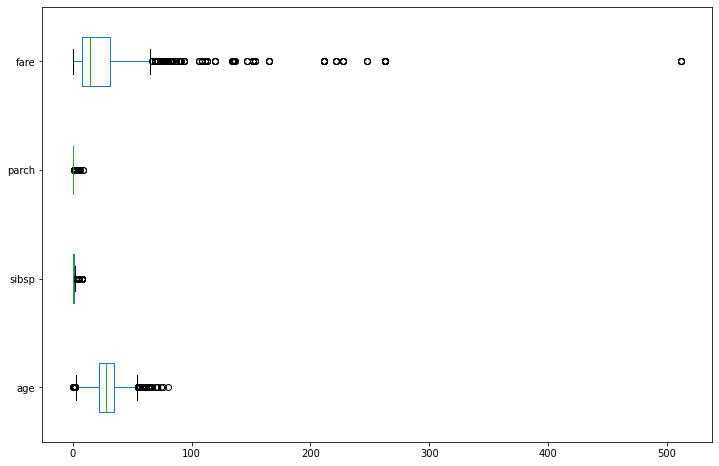

In [ ]:
numerical_columns = ["age", "sibsp", "parch", "fare"]

# Plotting out box plots for quantitative features
titanic_impute[numerical_columns].plot(kind='box', vert=False, figsize=(12, 8))
plt.show()

### Removing Outliers

$\text{Upper Fence} = Q3 + (1.5 * IQR)$

$\text{Lower Fence} = Q1 - (1.5 * IQR)$


In [ ]:
titanic_impute.shape

(1310, 7)

In [ ]:
# Calculating 25th, 75th Quartiles and the Interquartile Range 
Q1 = titanic_impute.quantile(0.25)
Q3 = titanic_impute.quantile(0.75)

In [ ]:
IQR = Q3 - Q1

In [ ]:
# Creating Lower and Upper Fence
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

In [ ]:
# Creating a condition where Outliers are False and vice versa
condition = ~((titanic_impute[numerical_columns] < lower_fence) | (titanic_impute[numerical_columns] > upper_fence)).any(axis=1)

In [ ]:
# Outliers outside the fences
titanic_outlier = titanic_impute.copy()
titanic_outlier = titanic_impute[condition]

display(titanic_outlier.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 859 entries, 5 to 1309
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    859 non-null    object 
 1   sex       859 non-null    object 
 2   age       859 non-null    float64
 3   sibsp     859 non-null    float64
 4   parch     859 non-null    float64
 5   fare      859 non-null    float64
 6   embarked  859 non-null    object 
dtypes: float64(4), object(3)
memory usage: 53.7+ KB


None

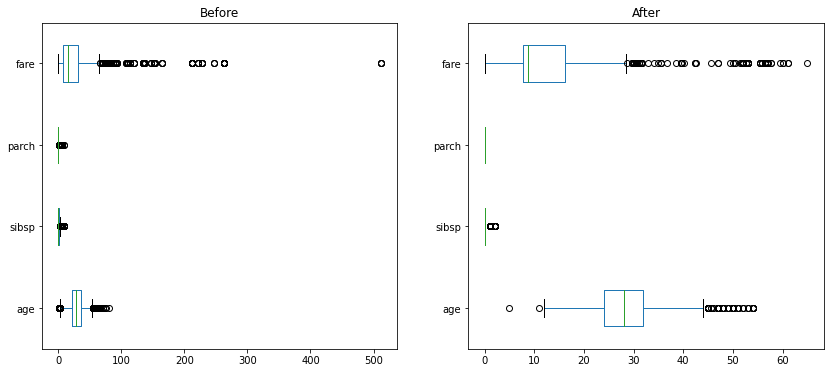

In [ ]:
# Creating a diagram to show the before and after results.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
titanic_impute[numerical_columns].plot(kind='box', vert=False, ax=ax1, title='Before')
titanic_outlier[numerical_columns].plot(kind='box', vert=False, ax=ax2, title='After')
plt.show()

<a name="_4"></a>
## Feature Scaling
The next step is to scale our features. You may ask, why is there a need for scaling? Some machine learning algorithms will be dependent on the spread of the feature, thus it will create some form of bias over the feature. Thus, it would be better if we scale our features before modelling. 

[Back to the Content Table](#Top)

### Standardisation
Standardization is a transformation that centers the data by removing the mean value of each feature and then scale it by dividing (non-constant) features by their standard deviation. After standardizing data the mean will be zero and the standard deviation one.<br><br>
Here we use StandardScaler from scikit-learn library to perform scaling on our feature.

In [ ]:
from sklearn.preprocessing import StandardScaler
titanic_scaled = titanic_impute.copy()

scaler = StandardScaler()

numerical_columns = ["age", "sibsp", "parch", "fare"]

titanic_scaled[numerical_columns] = scaler.fit_transform(titanic_scaled[numerical_columns])
display(titanic_scaled)

,pclass,sex,age,sibsp,parch,fare,embarked
0,1,female,-0.038931,-0.478862,-0.444796,3.444003,S
1,1,male,-2.216698,0.481795,1.867437,2.287674,S
2,1,female,-2.132692,0.481795,1.867437,2.287674,S
3,1,male,0.038615,0.481795,1.867437,2.287674,S
4,1,female,-0.349118,0.481795,1.867437,2.287674,S
...,...,...,...,...,...,...,...
1305,3,female,-0.116478,0.481795,-0.444796,-0.363846,C
1306,3,male,-0.232798,-0.478862,-0.444796,-0.503663,C
1307,3,male,-0.194025,-0.478862,-0.444796,-0.503663,C
1308,3,male,-0.038931,-0.478862,-0.444796,-0.491092,S


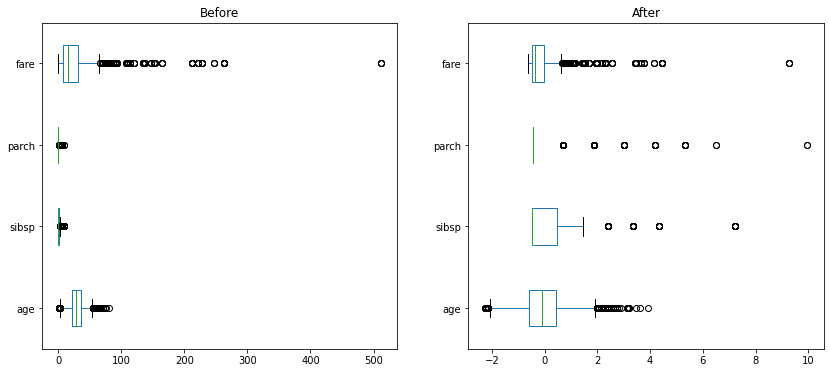

In [ ]:
# Creating a diagram to show the before and after results.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
titanic_impute[numerical_columns].plot(kind='box', vert=False, ax=ax1, title='Before')
titanic_scaled[numerical_columns].plot(kind='box', vert=False, ax=ax2, title='After')
plt.show()

<a name="_5"></a>
## Handling Categorical Feature
Transforming categorical features is an essential part process during data preprocessing, as sklearn machine learning library does not support handling categorical data. Therefore, it is necessary to convert categorical features into numerical representation, also known as encoding.

First step is to determine whether the feature is Ordinal (Can be Ordered) or Nominal (No Order or Ranking).

[Back to the Content Table](#Top)

In [ ]:
# Embarked - Location/Port of Embark
display(titanic_impute)

,pclass,sex,age,sibsp,parch,fare,embarked
0,1,female,29.0000,0.0,0.0,211.3375,S
1,1,male,0.9167,1.0,2.0,151.5500,S
2,1,female,2.0000,1.0,2.0,151.5500,S
3,1,male,30.0000,1.0,2.0,151.5500,S
4,1,female,25.0000,1.0,2.0,151.5500,S
...,...,...,...,...,...,...,...
1305,3,female,28.0000,1.0,0.0,14.4542,C
1306,3,male,26.5000,0.0,0.0,7.2250,C
1307,3,male,27.0000,0.0,0.0,7.2250,C
1308,3,male,29.0000,0.0,0.0,7.8750,S


### One-Hot encoding
The main idea is to convert each category value into a new column and assigns a 1 or 0 (True/False) value to the column. This has the benefit of not weighting a value improperly but does have the downside of adding more columns to the data set.

Pandas supports this feature using get_dummies. This function is named this way because it creates dummy/indicator variables (aka 1 or 0). 

In [ ]:
categorical_feature = ['sex', 'embarked']
titanic_onehot = pd.get_dummies(titanic_impute, columns = categorical_feature, drop_first=True)
display(titanic_onehot)

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,1,29.0000,0.0,0.0,211.3375,0,0,1
1,1,0.9167,1.0,2.0,151.5500,1,0,1
2,1,2.0000,1.0,2.0,151.5500,0,0,1
3,1,30.0000,1.0,2.0,151.5500,1,0,1
4,1,25.0000,1.0,2.0,151.5500,0,0,1
...,...,...,...,...,...,...,...,...
1305,3,28.0000,1.0,0.0,14.4542,0,0,0
1306,3,26.5000,0.0,0.0,7.2250,1,0,0
1307,3,27.0000,0.0,0.0,7.2250,1,0,0
1308,3,29.0000,0.0,0.0,7.8750,1,0,1


In [ ]:
# Deliberately show the before and after
embarked_before = pd.DataFrame(titanic_impute['embarked'])
embarked_before.join(titanic_onehot[['embarked_Q', 'embarked_S']])[510:525]

,embarked,embarked_Q,embarked_S
510,S,0,1
511,Q,1,0
512,C,0,0
513,C,0,0
514,S,0,1
515,S,0,1
516,S,0,1
517,S,0,1
518,S,0,1
519,S,0,1
